## Imports

In [32]:
import os 
import numpy as np
import mne

## Loading data 

In [33]:
sample_data_folder = mne.datasets.sample.data_path(path=None, force_update=False, update_path=True, download=True, verbose=None)
sample_data_raw_file = os.path.join(sample_data_folder, 'MEG', 'sample',
                                    'sample_audvis_filt-0-40_raw.fif')
raw = mne.io.read_raw_fif(sample_data_raw_file)

Opening raw data file /Users/parent/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.


In [34]:
print(raw)
print(raw.info)

<Raw | sample_audvis_filt-0-40_raw.fif, 376 x 41700 (277.7 s), ~3.3 MB, data not loaded>
<Info | 15 non-empty values
 bads: 2 items (MEG 2443, EEG 053)
 ch_names: MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, MEG 0121, MEG ...
 chs: 204 Gradiometers, 102 Magnetometers, 9 Stimulus, 60 EEG, 1 EOG
 custom_ref_applied: False
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 40.0 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 376
 projs: PCA-v1: off, PCA-v2: off, PCA-v3: off, Average EEG reference: off
 sfreq: 150.2 Hz
>


Effective window size : 13.639 (s)
Effective window size : 13.639 (s)
Effective window size : 13.639 (s)


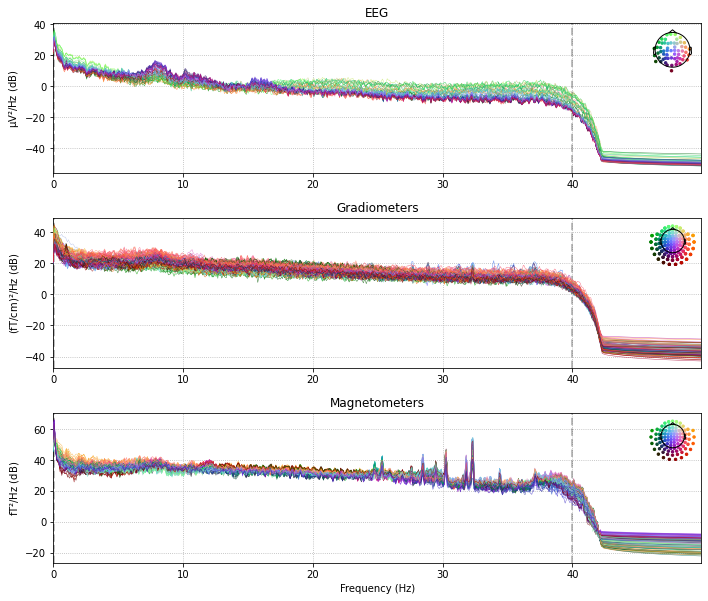

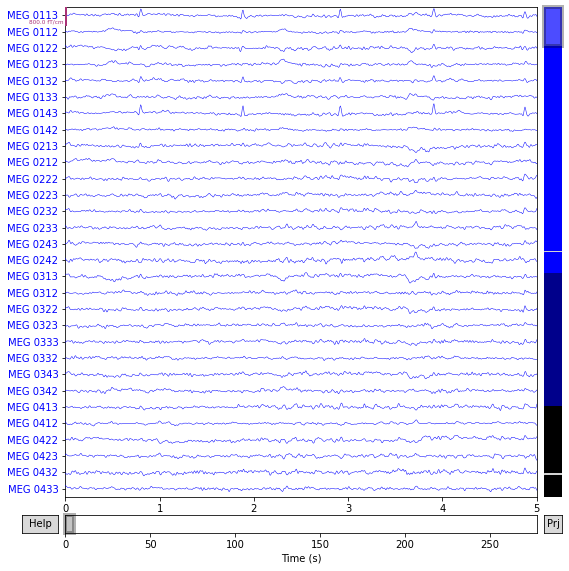

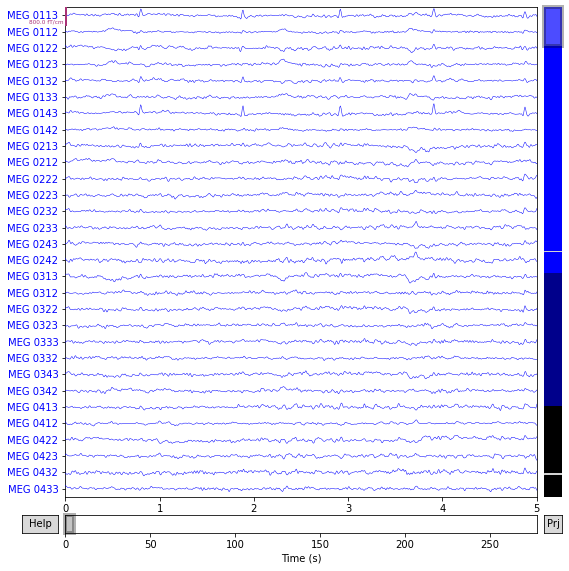

In [35]:
raw.plot_psd(fmax=50)
raw.plot(duration=5, n_channels=30)

## Preprocessing 

Fitting ICA to data using 364 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 4.1s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


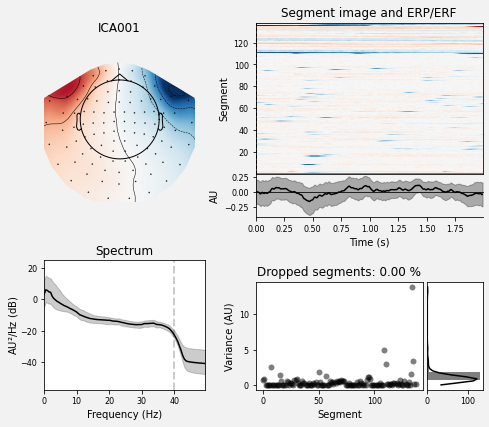

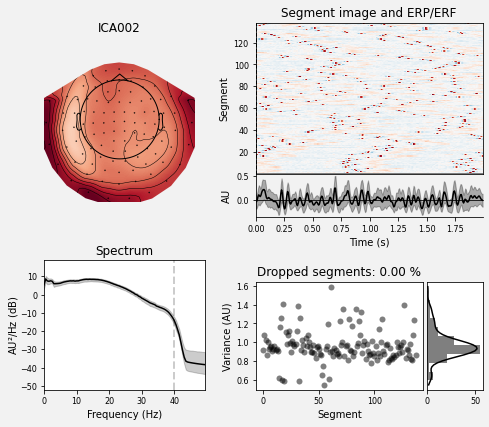

[<Figure size 504x432 with 6 Axes>, <Figure size 504x432 with 6 Axes>]

In [36]:
# set up and fit the ICA
ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800)
ica.fit(raw)
ica.exclude = [1, 2]  # details on how we picked these are omitted here
ica.plot_properties(raw, picks=ica.exclude)

Reading 0 ... 41699  =      0.000 ...   277.709 secs...
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 364 PCA components


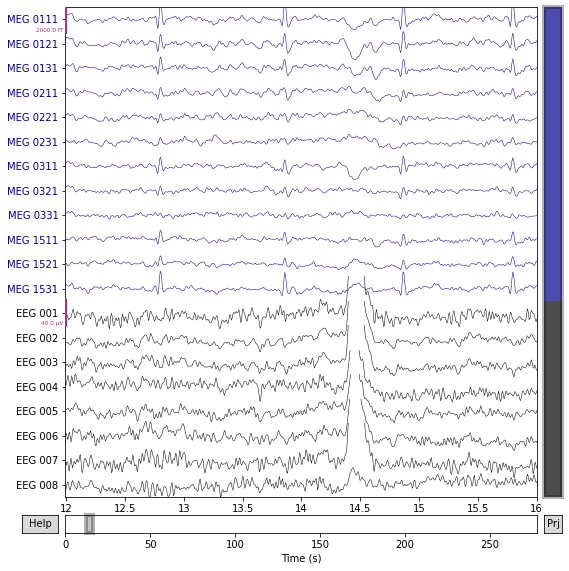

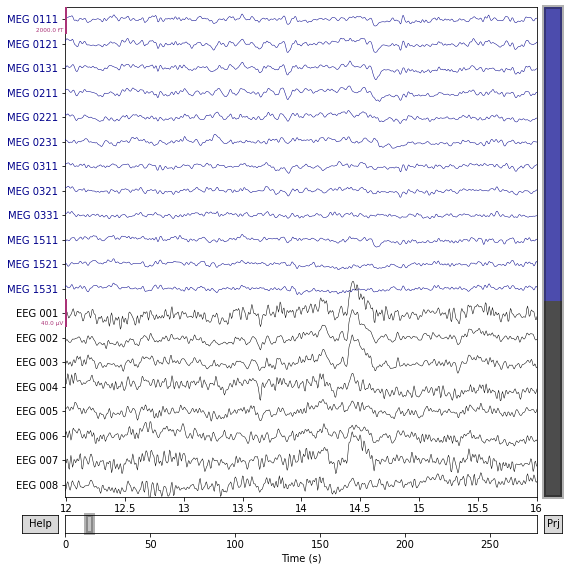

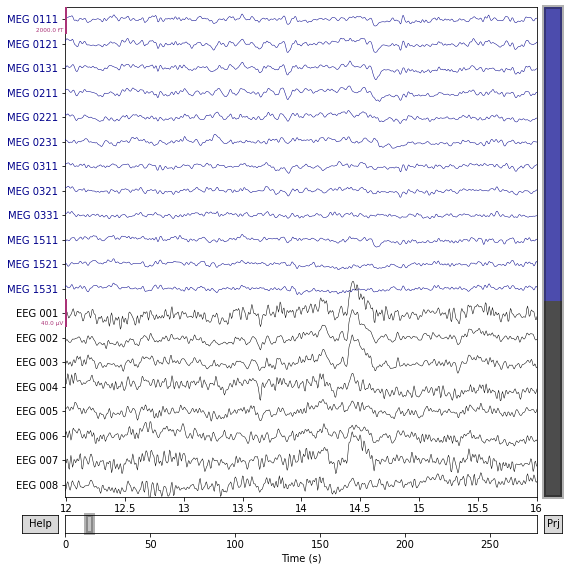

In [37]:
orig_raw = raw.copy()
raw.load_data()
ica.apply(raw)

# show some frontal channels to clearly illustrate the artifact removal
chs = ['MEG 0111', 'MEG 0121', 'MEG 0131', 'MEG 0211', 'MEG 0221', 'MEG 0231',
       'MEG 0311', 'MEG 0321', 'MEG 0331', 'MEG 1511', 'MEG 1521', 'MEG 1531',
       'EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 005', 'EEG 006',
       'EEG 007', 'EEG 008']
chan_idxs = [raw.ch_names.index(ch) for ch in chs]
orig_raw.plot(order=chan_idxs, start=12, duration=4)
raw.plot(order=chan_idxs, start=12, duration=4)

## Detecting experimental events 

In [38]:
events = mne.find_events(raw, stim_channel='STI 014')
print(events[:5])  # show the first 5

319 events found
Event IDs: [ 1  2  3  4  5 32]
[[6994    0    2]
 [7086    0    3]
 [7192    0    1]
 [7304    0    4]
 [7413    0    2]]


In [39]:
event_dict = {'auditory/left': 1, 'auditory/right': 2, 'visual/left': 3,
              'visual/right': 4, 'smiley': 5, 'buttonpress': 32}

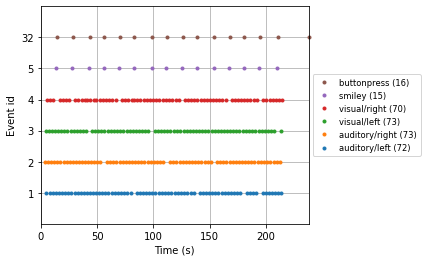

In [40]:
fig = mne.viz.plot_events(events, event_id=event_dict, sfreq=raw.info['sfreq'],
                          first_samp=raw.first_samp)

## Epoching continuous data

In [41]:
reject_criteria = dict(mag=4000e-15,     # 4000 fT
                       grad=4000e-13,    # 4000 fT/cm
                       eeg=150e-6,       # 150 µV
                       eog=250e-6)       # 250 µV

In [42]:
epochs = mne.Epochs(raw, events, event_id=event_dict, tmin=-0.2, tmax=0.5,
                    reject=reject_criteria, preload=True)

Not setting metadata
Not setting metadata
319 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] sec
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 4)
4 projection items activated
Loading data for 319 events and 106 original time points ...
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EEG : ['EEG 008']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
10 bad epochs dropped


In [43]:
conds_we_care_about = ['auditory/left', 'auditory/right',
                       'visual/left', 'visual/right']
epochs.equalize_event_counts(conds_we_care_about)  # this operates in-place
aud_epochs = epochs['auditory']
vis_epochs = epochs['visual']
del raw, epochs  # free up memory

Dropped 7 epochs: 121, 195, 258, 271, 273, 274, 275


Not setting metadata
Not setting metadata
136 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
136 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


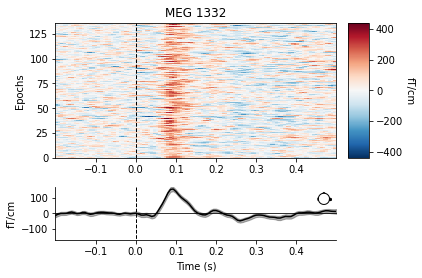

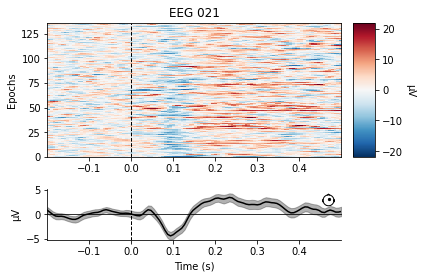

[<Figure size 432x288 with 4 Axes>, <Figure size 432x288 with 4 Axes>]

In [44]:
aud_epochs.plot_image(picks=['MEG 1332', 'EEG 021'])

## Time-frequency analysis

Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>
Removing projector <Projection | Average EEG reference, active : True, n_channels : 60>
Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>
Removing projector <Projection | Average EEG reference, active : True, n_channels : 60>
No baseline correction applied


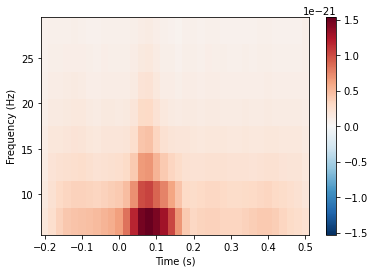

[<Figure size 432x288 with 2 Axes>]

In [45]:
frequencies = np.arange(7, 30, 3)
power = mne.time_frequency.tfr_morlet(aud_epochs, n_cycles=2, return_itc=False,
                                      freqs=frequencies, decim=3)
power.plot(['MEG 1332'])

## Estimating evoked responses

Multiple channel types selected, returning one figure per type.
combining channels using "gfp"
combining channels using "gfp"


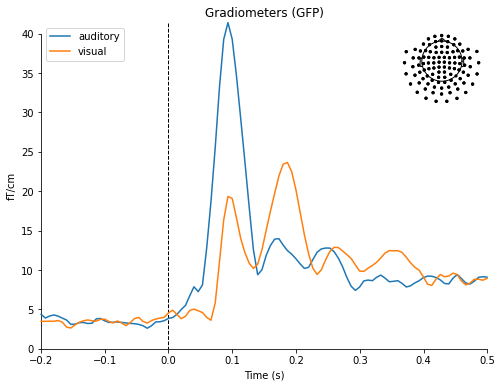

combining channels using "gfp"
combining channels using "gfp"


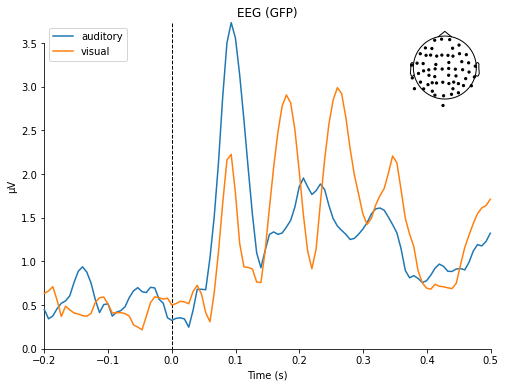

combining channels using "gfp"
combining channels using "gfp"


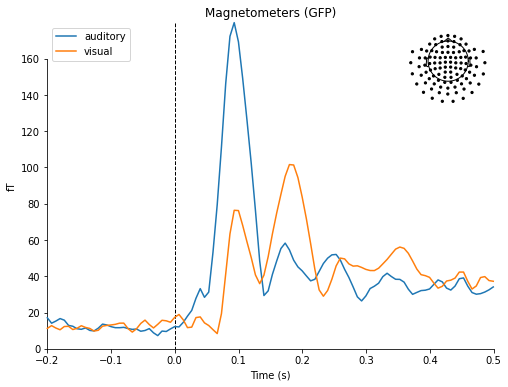

[<Figure size 576x432 with 2 Axes>,
 <Figure size 576x432 with 2 Axes>,
 <Figure size 576x432 with 2 Axes>]

In [46]:
aud_evoked = aud_epochs.average()
vis_evoked = vis_epochs.average()

mne.viz.plot_compare_evokeds(dict(auditory=aud_evoked, visual=vis_evoked),
                             legend='upper left', show_sensors='upper right')

Projections have already been applied. Setting proj attribute to True.
Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>


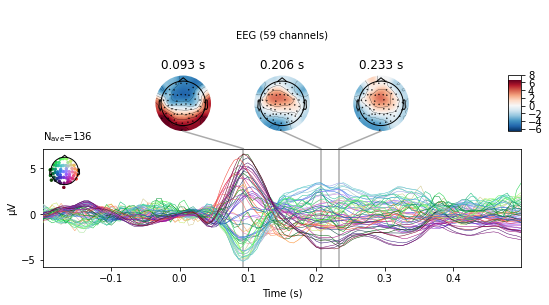

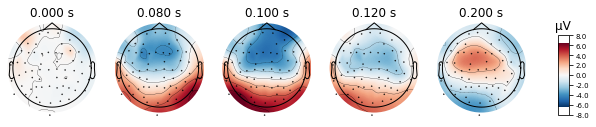

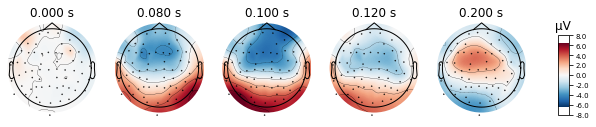

In [47]:
aud_evoked.plot_joint(picks='eeg')
aud_evoked.plot_topomap(times=[0., 0.08, 0.1, 0.12, 0.2], ch_type='eeg')

Removing projector <Projection | Average EEG reference, active : True, n_channels : 60>


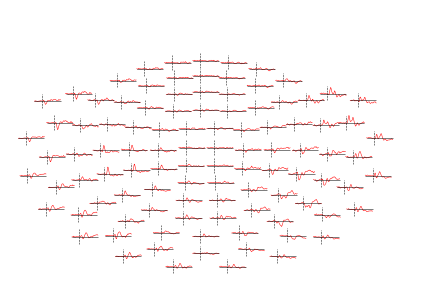

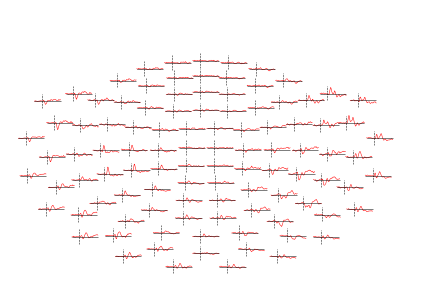

In [48]:
evoked_diff = mne.combine_evoked([aud_evoked, vis_evoked], weights=[1, -1])
evoked_diff.pick_types(meg='mag').plot_topo(color='r', legend=False)

## Inverse modeling

In [49]:
# load inverse operator
inverse_operator_file = os.path.join(sample_data_folder, 'MEG', 'sample',
                                     'sample_audvis-meg-oct-6-meg-inv.fif')
inv_operator = mne.minimum_norm.read_inverse_operator(inverse_operator_file)
# set signal-to-noise ratio (SNR) to compute regularization parameter (λ²)
snr = 3.
lambda2 = 1. / snr ** 2
# generate the source time course (STC)
stc = mne.minimum_norm.apply_inverse(vis_evoked, inv_operator,
                                     lambda2=lambda2,
                                     method='MNE')  # or dSPM, sLORETA, eLORETA

Reading inverse operator decomposition from /Users/parent/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-oct-6-meg-inv.fif...
    Reading inverse operator info...
    [done]
    Reading inverse operator decomposition...
    [done]
    305 x 305 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
    Noise covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 2) found.
    Source covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 6) found.
    Orientation priors read.
    22494 x 22494 diagonal covariance (kind = 5) found.
    Depth priors read.
    Did not find the desired covariance matrix (kind = 3)
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing p

In [50]:
# path to subjects' MRI files
subjects_dir = os.path.join(sample_data_folder, 'subjects')
# plot the STC
stc.plot(initial_time=0.1, hemi='split', views=['lat', 'med'],
         subjects_dir=subjects_dir)

/var/folders/dy/n5f7y8ms3137bqhcms4jx2nw0000gn/T/ipykernel_33575/249633968.py:4: DeprecationWarning: The Mayavi 3D backend is deprecated in 0.24 and will be removed in the next version of MNE-Python. Use the pyvistaqt or notebook backends instead
  stc.plot(initial_time=0.1, hemi='split', views=['lat', 'med'],
/var/folders/dy/n5f7y8ms3137bqhcms4jx2nw0000gn/T/ipykernel_33575/249633968.py:4: DeprecationWarning: The Mayavi 3D backend is deprecated in 0.24 and will be removed in the next version of MNE-Python. Use the pyvistaqt or notebook backends instead
  stc.plot(initial_time=0.1, hemi='split', views=['lat', 'med'],
/var/folders/dy/n5f7y8ms3137bqhcms4jx2nw0000gn/T/ipykernel_33575/249633968.py:4: DeprecationWarning: The Mayavi 3D backend is deprecated in 0.24 and will be removed in the next version of MNE-Python. Use the pyvistaqt or notebook backends instead
  stc.plot(initial_time=0.1, hemi='split', views=['lat', 'med'],


ImportError: cannot import name 'Brain' from 'surfer' (/Users/parent/opt/anaconda3/envs/mne/lib/python3.10/site-packages/surfer/__init__.py)